# Download GitHub repository

In [1]:
%cd ~/content/
%rm -rf ~/content/ActionPrediction4CA
%rm -rf ~/content/ActionPredictionBERT
!git clone  --branch colab_exe https://github.com/jmcrav/ActionPrediction4CA.git

/home/gian/content
Clone in 'ActionPrediction4CA' in corso...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (360/360), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 360 (delta 179), reused 254 (delta 81), pack-reused 0
Ricezione degli oggetti: 100% (360/360), 46.95 MiB | 10.50 MiB/s, fatto.
Risoluzione dei delta: 100% (179/179), fatto.


# Elimino i file inutili al modello 
Per fare il fine tuning del modello, abbiamo bisogno solo dei dati grezzi.
Il tutor ha puntualizzato di usare SOLO lo script `simmc/mm_action_prediction/tools/extract_actions_fashion.py`, che costruisce un json con le lables associate alle azioni e agli attributi (è lo step 1 del preprocessing).
Questo credo sia necessario perchè credo che la loro implementazione sia di un livello molto più basso di quello a cui dovremo lavorare noi.
BERT è un metodo per effettuare il  pre-trained di modelli per il NLP di cui dobbiamo solo fare un fine-tuning accettabile, mentre il SIMMC deve addestrare un intero modello da zero(o comunque credo che il loro obiettivo sia cercare di creare un modello che riesca a funzionare bene col linguaggio multimodale.Non ho capito perchè non sia statu usato BERT anche da loro onestamente -  il task finale è diviso in 3 sottotask, e la prima è un problema di classificazione multi-classe per il quale BERT dovrebbe poter funzionare - forse perchè quella fornita è solo un implementazione di partenza e i concorrenti alla challenge hanno fornito le loro implementazioni dei modelli?). Praticamente tutte le operazioni che fanno loro sui dati credo servano ai loro dettagli implementativi di bassissimo livello; con BERT noi dovremo usare solo i metodi forniti dalla classe.
In pratica, partendo dai dati grezzi, dobbiamo solo darli in pasto ai metodi forniti da BERT e magari lavorare un po' per migliorare i risultati, senza che sia necessario scendere fino al livello dei transformers


**DA TENERE**
* Output dell'extract actions
*  `fashion_train_dials.json`:  per il training
*  `fashion_dev_dials.json` : per la validation
*  `fashion_teststd_dials_public.json` :per il "report dei risultati finali" (forse per darlo in pasto allo script di evaluation?) 
*   `fashion_metadata.json`, `fashion_devtest_dials.json` : necessari per il funzionamento dello script `extract_actions_fashion.py `

**DA VERIFICARE**:

 forse potrebbe convenire anche usare il vocabolario che loro si costruiscono (step 2 del preprocessing) per inizializzare il Tokenizer di Bert, come fanno loro nel data loader (in `loaders/loader_simmc.py`)
 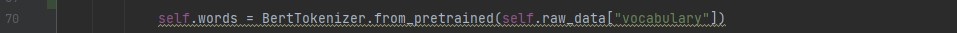

 Questo comando istanzia il tokenizer con una versione default o definita dall'utente (devo capire bene cosa significa, l'ho letto su https://huggingface.co/transformers/quickstart.html)



In [2]:
%mkdir ~/content/ActionPredictionBERT ActionPredictionBERT/input_data ActionPredictionBERT/extr_output
%cd ~/content/ActionPrediction4CA/tools
%mv extract_actions_fashion.py ~/content/ActionPredictionBERT
%mv action_evaluation.py ~/content/ActionPredictionBERT

%cd ~/content/ActionPrediction4CA/data/simmc_fashion/
%mv fashion_train_dials.json fashion_dev_dials.json fashion_teststd_dials_public.json fashion_metadata.json fashion_devtest_dials.json ~/content/ActionPredictionBERT/input_data
%cd ~/content/
%rm -rf ./ActionPrediction4CA/

/home/gian/content/ActionPrediction4CA/tools
/home/gian/content/ActionPrediction4CA/data/simmc_fashion
/home/gian/content


# Extract_actions_fashion

In [3]:
%cd ~/content/ActionPredictionBERT/
!python extract_actions_fashion.py --json_path="./input_data/fashion_train_dials.json ./input_data/fashion_dev_dials.json ./input_data/fashion_devtest_dials.json" --save_root="./extr_output"  --metadata_path="./fashion_metadata.json"

/home/gian/content/ActionPredictionBERT
Reading: ./input_data/fashion_train_dials.json
Dialogue task Id missing: 3406
Dialogue task Id missing: 3969
Dialogue task Id missing: 4847
Dialogue task Id missing: 321
Dialogue task Id missing: 3455
Dialogue task Id missing: 3414
Saving: ./extr_output/fashion_train_dials_api_calls.json
Reading: ./input_data/fashion_dev_dials.json
Dialogue task Id missing: 2117
Saving: ./extr_output/fashion_dev_dials_api_calls.json
Reading: ./input_data/fashion_devtest_dials.json
Dialogue task Id missing: 9308
Saving: ./extr_output/fashion_devtest_dials_api_calls.json


# Notebook originale
Script copiato dal colab di Chris McCormick e Nick Ryan
https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=nSU7yERLP_66

## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [4]:
#!pip install markdown
#!pip install transformers
#!pip install pandas
#!pip install torch

# Impostazione parametri esecuzione

In [5]:
exec_params = {
    'batch': 12,
    'epochs': 10,
    'hidden_output_dim': 256
}

# Analisi Dataset

## train_dials

Dati grezzi da preprocessare con lo script

In [6]:
#prima parte del fashion_train_dials
import json 
import pandas as pd
with open ('./input_data/fashion_train_dials.json',"r") as f:
   data= json.load(f)

result=[]
row ={}
for k in data:
  row[k] = data[k]
# []
#prima parte del fashion_train_dials
import json 
import pandas as pd
with open ('./input_data/fashion_train_dials.json',"r") as f:
   data= json.load(f)

result=[]
row ={}
for k in data:
  row[k] = data[k]
# []

dialogue_data = pd.json_normalize(row['dialogue_data'])
type(dialogue_data)
# dialogue = dialogue_data["dialogue"]
# for x in dialogue.head(1):
#   display(x)
# #dialogue.head(1)
dialogue_data.head()



dialogue_data = pd.json_normalize(row['dialogue_data'])
type(dialogue_data)
# dialogue = dialogue_data["dialogue"]
# for x in dialogue.head(1):
#   display(x)
# #dialogue.head(1)
dialogue_data.head()




,dialogue,dialogue_idx,domains,dialogue_task_id,dialogue_coref_map.1426,dialogue_coref_map.1429,dialogue_coref_map.708,dialogue_coref_map.712,dialogue_coref_map.2401,dialogue_coref_map.2402,...,dialogue_coref_map.2335,dialogue_coref_map.713,dialogue_coref_map.1507,dialogue_coref_map.1509,dialogue_coref_map.949,dialogue_coref_map.1137,dialogue_coref_map.1872,dialogue_coref_map.1873,dialogue_coref_map.1753,dialogue_coref_map.834
0,[{'belief_state': [{'act': 'DA:ASK:CHECK:CLOTH...,3094,[fashion],1785.0,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[{'belief_state': [{'act': 'DA:INFORM:PREFER:C...,822,[fashion],1720.0,NaN,NaN,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[{'belief_state': [{'act': 'DA:REQUEST:GET:CLO...,7411,[fashion],2038.0,NaN,NaN,NaN,NaN,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[{'belief_state': [{'act': 'DA:INFORM:DISPREFE...,7029,[fashion],2011.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[{'belief_state': [{'act': 'DA:INFORM:DISPREFE...,1506,[fashion],1686.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#seconda parte del fashion_train_dials
task_mapping = pd.json_normalize(row['task_mapping'])
task_mapping.head()


,task_id,image_ids,focus_image,memory_images,database_images
0,2042,"[2441, 2442, 2443, 2444, 2445, 2446, 2447, 244...",2441,"[2442, 2443, 2444]","[2445, 2446, 2447, 2448, 2449, 2450]"
1,2041,"[2431, 2432, 2433, 2434, 2435, 2436, 2437, 243...",2431,"[2432, 2433, 2434]","[2435, 2436, 2437, 2438, 2439, 2440]"
2,2040,"[2421, 2422, 2423, 2424, 2425, 2426, 2427, 242...",2421,"[2422, 2423, 2424]","[2425, 2426, 2427, 2428, 2429, 2430]"
3,2039,"[2411, 2412, 2413, 2414, 2415, 2416, 2417, 241...",2411,"[2412, 2413, 2414]","[2415, 2416, 2417, 2418, 2419, 2420]"
4,2038,"[2401, 2402, 2403, 2404, 2405, 2406, 2407, 240...",2401,"[2402, 2403, 2404]","[2405, 2406, 2407, 2408, 2409, 2410]"


## dev_dials_api_calls

In [8]:
import pandas as pd
dev_dials_api = pd.read_json('./extr_output/fashion_dev_dials_api_calls.json')
dev_dials_api.head()


,dialog_id,actions,focus_images
0,4146,"[{'turn_idx': 0, 'action': 'None', 'action_sup...","[1646, 1646, 1646, 1649, 1649, 1649, 1649]"
1,4260,"[{'turn_idx': 0, 'action': 'SpecifyInfo', 'act...","[2161, 2161, 2161, 2161]"
2,8022,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1971, 1972, 1972, 1972, 1977, 1978]"
3,4992,"[{'turn_idx': 0, 'action': 'None', 'action_sup...","[1931, 1931, 1936, 1936, 1936]"
4,5606,"[{'turn_idx': 0, 'action': 'None', 'action_sup...","[1931, 1931, 1931, 1931, 1931]"


## devtest_dials_api_calls

In [9]:
import pandas as pd
devtest_dials_api = pd.read_json('./extr_output/fashion_devtest_dials_api_calls.json')
devtest_dials_api.head()

,dialog_id,actions,focus_images
0,2494,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1836, 1841, 1841, 1841, 1841]"
1,3731,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1676, 1681, 1681, 1683, 1683]"
2,8546,"[{'turn_idx': 0, 'action': 'SpecifyInfo', 'act...","[840, 840, 840, 849, 849, 843]"
3,5590,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1616, 1618, 1618, 1618, 1618]"
4,5452,"[{'turn_idx': 0, 'action': 'SpecifyInfo', 'act...","[2231, 2231, 2231, 2236, 2236]"


## Funzione generazione dataframe

In [10]:
import pandas as pd
import json

def createDataframe(json_file):
  with open(json_file) as f:
    dictftdac = json.load(f)

  data = []

  for e in dictftdac:
    dialog_id = e['dialog_id']
    actions = e['actions']
    focus_images = e['focus_images']

    for a in actions:
      
      turn_idx = a['turn_idx']
      action = a['action']
      action_supervision = a['action_supervision']
      transcript = a['transcript']
      transcript_annotated = a['transcript_annotated']
      system_transcript = a['system_transcript']
      system_transcript_annotated = a['system_transcript_annotated']

      row = {
          "dialog_id" : dialog_id,
          'turn_idx' : turn_idx,
          'action' : action,
          'action_supervision' : action_supervision,
          'focus_images' : focus_images,
          'transcript': transcript,
          'transcript_annotated': transcript_annotated,
          'system_transcript': system_transcript,
          'system_transcript_annotated':system_transcript_annotated,
          'previous_transcript': "",
          'previous_system_transcript': ""
      }
      if (action_supervision != None):
        if 'focus' in action_supervision:
          acsf = {'focus':action_supervision['focus']}
        else:
          acsf = {'focus':None}
        
        if 'attributes' in action_supervision:
          acsa = {'attributes':action_supervision['attributes']}
        else:
          acsa = {'attributes':[]}
      else:
          acsf = {'focus':None}
          acsa = {'attributes':[]}
      
        
      row.update(acsf)
      row.update(acsa)
    
      data.append(row)

  # Conservo id turno e risposta sistema per provare a implementare una soluzione articolata
  df = pd.DataFrame(data,columns=['dialog_id','turn_idx','transcript','action','attributes', 'system_transcript','transcript_annotated','system_transcript_annotated','previous_transcript','previous_system_transcript'])

  return df

## train_dials_api_calls with transcript
Dati per il training che usiamo ( per ora semplificati)

In [11]:
df_training = createDataframe('./extr_output/fashion_train_dials_api_calls.json')
print("Training: ",len(df_training)," elementi")

Training:  21196  elementi


## fashion_dev_dials_api_calls
Dati per la validation 

In [12]:
df_validation = createDataframe('./extr_output/fashion_dev_dials_api_calls.json')
print("Validation: ",len(df_validation)," elementi")

Validation:  3513  elementi


## fashion_devtest_dials_api_calls
Dati per la valutazione delle performance del modello (test set)

In [13]:
df_test = createDataframe('./extr_output/fashion_devtest_dials_api_calls.json')
print("Test: ",len(df_test)," elementi")

Test:  5397  elementi


# BERT model

## Scelta tipo input

Il valore di questa variabile determinerà se utilizzare i singoli transcript, o se concatenare ogni transcript a quello successivo

In [14]:
use_next = True

## Preparazione input

### Generazione colonna previous_transcript

Generazione della colonna contenente la frase del turno successivo del dialogo (se presente)

In [15]:
#Training
df_training.sort_values(by=['dialog_id', 'turn_idx'])
for i in range(1,(len(df_training))):
  if(i<(len(df_training)) and  df_training['dialog_id'][i] == df_training['dialog_id'][i-1]):
    df_training.loc[i,'previous_transcript'] = df_training['transcript'][i-1]
    df_training.loc[i,'previous_system_transcript'] = df_training['system_transcript'][i-1]

#Validation
df_validation.sort_values(by=['dialog_id', 'turn_idx'])
for i in range(1,(len(df_validation))):
  if(i<(len(df_validation)) and  df_validation['dialog_id'][i] == df_validation['dialog_id'][i-1]):
    df_validation.loc[i,'previous_transcript'] = df_validation['transcript'][i-1]
    df_validation.loc[i,'previous_system_transcript'] = df_validation['system_transcript'][i-1]

#Evaluation
df_test.sort_values(by=['dialog_id', 'turn_idx'])
for i in range(1,(len(df_test))):
  if(i<(len(df_test)) and  df_test['dialog_id'][i] == df_test['dialog_id'][i-1]):
    df_test.loc[i,'previous_transcript'] = df_test['transcript'][i-1]
    df_test.loc[i,'previous_system_transcript'] = df_test['system_transcript'][i-1]

### Estrazione vettori colonna

In [16]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


#### Training

In [17]:
transcripts_tr = df_training.transcript.values
previous_transcript_tr = df_training.previous_transcript.values
previous_system_transcript_tr = df_training.previous_system_transcript.values
action_labels_tr = df_training.action.values
attributes_labels_tr=df_training.attributes.values

print ("TRAINING DATA:")
# Print the original sentence.
print(' Original: ', transcripts_tr[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(transcripts_tr[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(transcripts_tr[0])))


TRAINING DATA:
 Original:  Is there a pattern on this one? It's hard to see in the image.
Tokenized:  ['is', 'there', 'a', 'pattern', 'on', 'this', 'one', '?', 'it', "'", 's', 'hard', 'to', 'see', 'in', 'the', 'image', '.']
Token IDs:  [2003, 2045, 1037, 5418, 2006, 2023, 2028, 1029, 2009, 1005, 1055, 2524, 2000, 2156, 1999, 1996, 3746, 1012]


In [18]:
for k in range(0,10):
  print(f"T: {transcripts_tr[k]} | PT: {previous_transcript_tr[k]} | PST: {previous_system_transcript_tr[k]}")

T: Is there a pattern on this one? It's hard to see in the image. | PT:  | PST: 
T: That's fancy. Do you have anything in warmer colors like yellow or red? | PT: Is there a pattern on this one? It's hard to see in the image. | PST: I don't have any information on the pattern, but it has pointelle embellishments.
T: Yeah, that sounds good. | PT: That's fancy. Do you have anything in warmer colors like yellow or red? | PST: I have a crew neck sweater in red, would you like to see it?
T: Oh, I love that. Please tell me you have a small. | PT: Yeah, that sounds good. | PST: This is $187 from Downtown Stylists with a 3.62 rating.
T: Yes, please! Thank you for your help with this | PT: Oh, I love that. Please tell me you have a small. | PST: It does come in small, shall I put one in your cart?
T: How nice! Does this come in other colors? | PT:  | PST: 
T: Oh well.  Can you show me a dress that comes in red? | PT: How nice! Does this come in other colors? | PST: No, I'm sorry, It comes only i

#### Validation

In [19]:
transcripts_vd = df_validation.transcript.values
previous_transcript_vd = df_validation.previous_transcript.values
previous_system_transcript_vd = df_validation.previous_system_transcript.values
action_labels_vd = df_validation.action.values
attributes_labels_vd=df_validation.attributes.values
dialog_ids_vd = df_validation.dialog_id.values
turn_idxs_vd = df_validation.turn_idx.values

print ("VALIDATION DATA:")

# Print the original sentence.
print(' Original: ', transcripts_vd[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(transcripts_vd[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(transcripts_vd[0])))

# Print the dialog ids.
print(f"Dialog IDs: {dialog_ids_vd[0:20]}")

# Print the turn idxs.
print(f"Turn IDs: {turn_idxs_vd[0:20]}")

VALIDATION DATA:
 Original:  What's the price of this sweater compared to the other blue and gray one I looked at?
Tokenized:  ['what', "'", 's', 'the', 'price', 'of', 'this', 'sweater', 'compared', 'to', 'the', 'other', 'blue', 'and', 'gray', 'one', 'i', 'looked', 'at', '?']
Token IDs:  [2054, 1005, 1055, 1996, 3976, 1997, 2023, 14329, 4102, 2000, 1996, 2060, 2630, 1998, 3897, 2028, 1045, 2246, 2012, 1029]
Dialog IDs: [4146 4146 4146 4146 4146 4146 4146 4260 4260 4260 4260 8022 8022 8022
 8022 8022 8022 4992 4992 4992]
Turn IDs: [0 1 2 3 4 5 6 0 1 2 3 0 1 2 3 4 5 0 1 2]


#### Evaluation


In [20]:
transcripts_tst = df_test.transcript.values
previous_transcript_tst = df_test.previous_transcript.values
previous_system_transcript_tst = df_test.previous_system_transcript.values
action_labels_tst = df_test.action.values
attributes_labels_tst=df_test.attributes.values
dialog_ids_tst = df_test.dialog_id.values
turn_idxs_tst = df_test.turn_idx.values

print ("EVALUATION DATA:")

# Print the original sentence.
print(' Original: ', transcripts_tst[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(transcripts_tst[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(transcripts_tst[0])))

# Print the dialog ids.
print(f"Dialog IDs: {dialog_ids_tst[0:20]}")

# Print the turn idxs.
print(f"Turn IDs: {turn_idxs_tst[0:20]}")

EVALUATION DATA:
 Original:  That looks a little too light for what I need, do you have something else with a high customer rating?
Tokenized:  ['that', 'looks', 'a', 'little', 'too', 'light', 'for', 'what', 'i', 'need', ',', 'do', 'you', 'have', 'something', 'else', 'with', 'a', 'high', 'customer', 'rating', '?']
Token IDs:  [2008, 3504, 1037, 2210, 2205, 2422, 2005, 2054, 1045, 2342, 1010, 2079, 2017, 2031, 2242, 2842, 2007, 1037, 2152, 8013, 5790, 1029]
Dialog IDs: [2494 2494 2494 2494 2494 3731 3731 3731 3731 3731 8546 8546 8546 8546
 8546 8546 5590 5590 5590 5590]
Turn IDs: [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 5 0 1 2 3]


## Calcolo dimensione massima

The above code left out a few required formatting steps that we'll look at here.

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".


The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:


1.   All sentences must be padded or truncated to a single, fixed length.
2.   The maximum sentence length is 512 tokens.


Padding is done with a special [PAD] token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

### Training

In [21]:
max_len_tr = 0

# For every sentence...
for i in range(0,len(transcripts_tr)):
    
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    if (previous_transcript_tr[i] != "" and use_next):
      input_ids = tokenizer.encode(previous_transcript_tr[i]+ " " + previous_system_transcript_tr[i],transcripts_tr[i], add_special_tokens=True)
    else:
      input_ids = tokenizer.encode(transcripts_tr[i], add_special_tokens=True)
        
    # Update the maximum sentence length.
    max_len_tr = max(max_len_tr, len(input_ids))

print('Max transcript length for training: ', max_len_tr)

Max transcript length for training:  177


### Validation

In [22]:
max_len_vd = 0

# For every sentence...
for i in range(0,len(transcripts_vd)):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    if (previous_transcript_vd[i] != "" and use_next):
      input_ids = tokenizer.encode(previous_transcript_vd[i]+ " " + previous_system_transcript_vd[i],transcripts_vd[i], add_special_tokens=True)
    else:
      input_ids = tokenizer.encode(transcripts_vd[i], add_special_tokens=True)
    
    # Update the maximum sentence length.
    max_len_vd = max(max_len_vd, len(input_ids))

print('Max transcript length for validation: ', max_len_vd)

Max transcript length for validation:  133


### Test

In [23]:
max_len_tst = 0

#non sono sicuro che il controllo della lunghezza vada fatto anche sul test set, dopo la performance non è determinata
#dalla conoscenza del test set?
#è anche vero che in teoria per far funzionare BERT bisogna dargli in pasto dei dati tokenizzati, quindi in un caso reale il nostro
#model non potrebbe prendere in ingresso del testo non trattato. Nel dubbio ho controllato le dimensioni

for i in range(0,len(transcripts_tst)):
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    if (previous_transcript_tst[i] != "" and use_next):
      input_ids = tokenizer.encode(previous_transcript_tst[i]+ " " + previous_system_transcript_tst[i],transcripts_tst[i], add_special_tokens=True)
    else:
      input_ids = tokenizer.encode(transcripts_tst[i], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_tst = max(max_len_tst, len(input_ids))

print("Max transcript length for evaluation: ",max_len_tst)

Max transcript length for evaluation:  150


### Risultato

In [24]:
max_len = max(max_len_tr, max_len_vd, max_len_tst)

# if (max_len_tr >= max_len_vd):
#   max_len = max_len_tr
# else:
#   max_len = max_len_vd
# if (max_len_tst >= max_len):
#   max_len = max_len_tst

print("La massima lunghezza dei token da gestire è quindi ",max_len)

La massima lunghezza dei token da gestire è quindi  177


## Label encoding

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

mlb = MultiLabelBinarizer()
attributes_labels_all = np.concatenate((attributes_labels_tr, attributes_labels_vd,attributes_labels_tst), axis=None)
attr_yt = mlb.fit_transform(attributes_labels_all)
print(attr_yt[0:15])
print(mlb.inverse_transform(attr_yt[3].reshape(1, -1)))
print(mlb.classes_)
print(f"Totale: {len(attr_yt)}, Training: {len(attributes_labels_tr)}, Validation: {len(attributes_labels_vd)}, Evaluation: {len(attributes_labels_tst)}")
attributes_labels_tr_vect = attr_yt[0:len(attributes_labels_tr)]
attributes_labels_vd_vect = attr_yt[len(attributes_labels_tr):(len(attributes_labels_tr)+len(attributes_labels_vd))]
attributes_labels_tst_vect = attr_yt[(len(attributes_labels_tr)+len(attributes_labels_vd)):]
print(f"Training: {len(attributes_labels_tr_vect)}, Validation: {len(attributes_labels_vd_vect)}, Evaluation: {len(attributes_labels_tst_vect)}")


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

## Tokenization

Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

Split the sentence into tokens.
Add the special [CLS] and [SEP] tokens.
Map the tokens to their IDs.
Pad or truncate all sentences to the same length.
Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks). Documentation is here.

In [26]:
import torch
import tensorflow as tf
# backends cudnn for out memory not necessary (resolved by batch size)
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True


### Tokenize Train Data

In [27]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

#dobbiamo convertire le nostre lables da string a valori numerici, usiamo il metodo fornito da sklearn

#TRAINING DATASET
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
action_labels_encoded_tr = le.fit_transform(action_labels_tr)

input_ids_tr = []
attention_masks_tr = []
print(f"{len(df_training)} records to encode.")
# For every sentence...
for i in range(0,len(df_training)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

  if (previous_transcript_tr[i] != "" and use_next):
    encoded_dict = tokenizer.encode_plus(
                        previous_transcript_tr[i]+ " " + previous_system_transcript_tr[i],  # Sentence to encode.
                        transcripts_tr[i], #next sentece to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                    )
  else:
    encoded_dict = tokenizer.encode_plus(
                        transcripts_tr[i],  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                    )
    

    
  # Add the encoded sentence to the list.    
  input_ids_tr.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks_tr.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_tr = torch.cat(input_ids_tr, dim=0)
attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
labels_actions_tr = torch.tensor(action_labels_encoded_tr)
labels_attributes_tr = torch.tensor(attributes_labels_tr_vect) 

# Print sentence 0, now as a list of IDs.
print ("TRAINING : ")
if (use_next):
  print('Original: ', transcripts_tr[0])
else:
  print('Original: ', transcripts_tr[0])
print('Token IDs:', input_ids_tr[0])

21196 records to encode.


/home/gian/anaconda3/envs/testcuda1/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TRAINING : 
Original:  Is there a pattern on this one? It's hard to see in the image.
Token IDs: tensor([ 101, 2003, 2045, 1037, 5418, 2006, 2023, 2028, 1029, 2009, 1005, 1055,
        2524, 2000, 2156, 1999, 1996, 3746, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

### Tokenize Validation Data

In [28]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

#dobbiamo convertire le nostre lables da string a valori numerici, usiamo il metodo fornito da sklearn

#VALIDATION DATASET
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
action_labels_encoded_vd = le.fit_transform(action_labels_vd)

input_ids_vd = []
attention_masks_vd = []
print(f"{len(df_validation)} records to encode.")
# For every sentence...
for i in range(0,len(df_validation)):
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.

  if (previous_transcript_vd[i] != "" and use_next):
    encoded_dict = tokenizer.encode_plus(
                        previous_transcript_vd[i]+ " " + previous_system_transcript_vd[i],  # Sentence to encode.
                        transcripts_vd[i], #next sentece to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                    )
  else:
    encoded_dict = tokenizer.encode_plus(
                        transcripts_vd[i],  # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                    )
    
  # Add the encoded sentence to the list.    
  input_ids_vd.append(encoded_dict['input_ids'])
  
  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks_vd.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_vd = torch.cat(input_ids_vd, dim=0)
attention_masks_vd = torch.cat(attention_masks_vd, dim=0)
labels_actions_vd = torch.tensor(action_labels_encoded_vd)
labels_attributes_vd = torch.tensor(attributes_labels_vd_vect)
# Check warning:
# /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
dialog_ids_vd = torch.tensor(dialog_ids_vd)
turn_idxs_vd = torch.tensor(turn_idxs_vd) 

# Print sentence 0, now as a list of IDs.
print ("VALIDATION : ")
if (use_next):
  print('Original: ', transcripts_vd[0])
else:
  print('Original: ', transcripts_vd[0])
print('Token IDs:', input_ids_vd[0])
print(f"Dialog IDs: {dialog_ids_vd[0:20]}")
print(f"Turn IDXs: {turn_idxs_vd[0:20]}")

3513 records to encode.
VALIDATION : 
Original:  What's the price of this sweater compared to the other blue and gray one I looked at?
Token IDs: tensor([  101,  2054,  1005,  1055,  1996,  3976,  1997,  2023, 14329,  4102,
         2000,  1996,  2060,  2630,  1998,  3897,  2028,  1045,  2246,  2012,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,    

### Tokenize Evaluation Data

In [29]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

#dobbiamo convertire le nostre lables da string a valori numerici, usiamo il metodo fornito da sklearn

#EVALUATION DATASET
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
action_labels_encoded_tst = le.fit_transform(action_labels_tst)

input_ids_tst = []
attention_masks_tst = []
print(f"{len(df_test)} records to encode.")
# For every sentence...
for i in range(0,len(df_test)):
# for t in transcripts_tst:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
  
  #Aggiungere "and False" PER UTILIZZARE sempre la tokenizzazione senza concatenazione
  if (previous_transcript_tst[i] != "" and use_next):
    encoded_dict = tokenizer.encode_plus(
                      previous_transcript_tst[i]+ " " + previous_system_transcript_tst[i],  # Sentence to encode.
                      transcripts_tst[i], #next sentece to encode
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      truncation = True,
                      max_length = max_len,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                  )
  else:
    encoded_dict = tokenizer.encode_plus(
                      transcripts_tst[i],  # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      truncation = True,
                      max_length = max_len,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                  )
    
  # Add the encoded sentence to the list.    
  input_ids_tst.append(encoded_dict['input_ids'])
  
  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks_tst.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_tst = torch.cat(input_ids_tst, dim=0)
attention_masks_tst = torch.cat(attention_masks_tst, dim=0)
labels_actions_tst = torch.tensor(action_labels_encoded_tst)
labels_attributes_tst = torch.tensor(attributes_labels_tst_vect)
# Check warning:
# /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
dialog_ids_tst = torch.tensor(dialog_ids_tst)
turn_idxs_tst = torch.tensor(turn_idxs_tst) 

# Print sentence 0, now as a list of IDs.
print ("Evaluation : ")
if (use_next):
  print('Original: ', transcripts_tst[0])
else:
  print('Original: ', transcripts_tst[0])
print('Token IDs:', input_ids_tst[0])
print(f"Dialog IDs: {dialog_ids_tst[0:20]}")
print(f"Turn IDXs: {turn_idxs_tst[0:20]}")

5397 records to encode.
Evaluation : 
Original:  That looks a little too light for what I need, do you have something else with a high customer rating?
Token IDs: tensor([ 101, 2008, 3504, 1037, 2210, 2205, 2422, 2005, 2054, 1045, 2342, 1010,
        2079, 2017, 2031, 2242, 2842, 2007, 1037, 2152, 8013, 5790, 1029,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,

# TRAINING

# Data Split - AP4CA
La nostra versione di split di dati per training e validation

In [30]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
#labels_tr = {'actions': labels_actions_tr, 'attributes': labels_attributes_tr}
#labels_vd = {'actions': labels_actions_vd, 'attributes': labels_attributes_vd}

train_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_actions_tr, labels_attributes_tr)
val_dataset = TensorDataset(input_ids_vd, attention_masks_vd, labels_actions_vd, labels_attributes_vd, dialog_ids_vd, turn_idxs_vd)
tst_dataset = TensorDataset(input_ids_tst, attention_masks_tst, labels_actions_tst, labels_attributes_tst, dialog_ids_tst, turn_idxs_tst)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))
print('{:>5,} evaluation samples'.format(len(tst_dataset)))

21,196 training samples
3,513 validation samples
5,397 evaluation samples


In [31]:
# Check evaluation TensorDataset content
tst_dataset[0:10]

(tensor([[ 101, 2008, 3504,  ...,    0,    0,    0],
         [ 101, 2008, 3504,  ...,    0,    0,    0],
         [ 101, 2040, 5617,  ...,    0,    0,    0],
         ...,
         [ 101, 2821, 1045,  ...,    0,    0,    0],
         [ 101, 4086, 1010,  ...,    0,    0,    0],
         [ 101, 1045, 2066,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([2, 4, 4, 0, 1, 2, 1, 2, 0, 1]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Check GPU for Training

In questa versione la GPU è impostata fissa.
Con una GPU in più a disposizione possiamo usare DataParallel e aumentare il batch size

In [32]:
# Tell PyTorch to use the GPU.    
device = torch.device("cuda")

print('There are %d GPU(s) available.' % torch.cuda.device_count())

print('We will use the GPU:', torch.cuda.get_device_name(0))


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2060


### Creazione Data Loaders per Training, Validation ed Evaluation

In [33]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# With size 32 GeForce RTX 2060 with 6GB run out of memory
batch_size = exec_params['batch']

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#ho controllato nel colab su cui ci basiamo, anche lui usa un Sequential Sampler per il dataset di evaluation
evaluation_dataloader = DataLoader(
            tst_dataset, # The validation samples.
            sampler = SequentialSampler(tst_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Train BERT model

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

NB anche nell'articolo che sto leggendo sulla classificazione multi-label si parte da questo modello


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [34]:
#DA SISTEMARE
from transformers import BertModel
from  torch import  nn

class CustomBERTModel(nn.Module):

  def __init__(self):

    super(CustomBERTModel, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    ### New layers:
    self.linear_intermedio = nn.Linear(768, exec_params['hidden_output_dim'])
    #provare ad aggiungere ulteriori layer intermedi per ridurre le dimensioni fino ad arrivare all'output richiesto
    self.linear_actions = nn.Linear(exec_params['hidden_output_dim'], 5) 
    self.linear_attributes = nn.Linear(exec_params['hidden_output_dim'], len(mlb.classes_)) #num attributi? 

  def forward(self, ids, mask):
    #controllare che l'output non rappresenti solo lo stato interno dovuto al token CLS
    output = self.bert(ids,attention_mask=mask)
    # print(f"Type output{type(output)}")
    # for p in output:
    #   print(p)
    #   print(type(output[p]))
    #   print(output[p])

    #prendiamo il campo last_hidden_state dall'oggetto output; last hidden state rappresenta il tensore
    #in uscita dallo step di forward del BertModel
    last_hidden_state_output = output["last_hidden_state"]
    # last_hidden_state has the following shape: (batch_size, sequence_length, 768)
    #stiamo passando solo il token CLS ai layer successivi
    linear_output_intermedio = self.linear_intermedio(last_hidden_state_output[:,0,:].view(-1,768)) 
    # linear_output_intermedio = self.linear_intermedio(pooled_output) 
    
    linear_output_actions = self.linear_actions(linear_output_intermedio)
    # linear_output_actions = self.sftmx(linear_output_actions)
    # linear_output_actions = nn.functional.softmax(linear_output_actions)
    # Test sigmoid for increasing perplexity performance
    linear_output_actions = torch.sigmoid(linear_output_actions)
    linear_output_attributes = self.linear_attributes(linear_output_intermedio)
    # linear_output_attributes = self.sig(linear_output_attributes)
    linear_output_attributes = torch.sigmoid(linear_output_attributes)

    return {'actions': linear_output_actions, 'attributes': linear_output_attributes}


In [35]:
#test istanziazione del custom model
model = CustomBERTModel()

# model.bert.config
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [36]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 205 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [37]:
from transformers import AdamW
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [38]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = exec_params['epochs']

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

### Flat accuracy

In [39]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy_actions(preds, labels):
    #print(f"[FA] preds: {preds} / labels: {labels}")
    #print(f"[FA-Actions] {type(preds)} {type(labels)}")
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()   
    return {'matched': np.sum(pred_flat == labels_flat), 'counts': len(labels_flat)}

def flat_accuracy_attributes(preds, labels):
  #print(f"[FA-Attributess] {type(preds)} {type(labels)}")
  tot_preds = preds.shape[0]
  preds_int = np.rint(preds)
  tot_eq = 0
  for i in range(tot_preds):
    comparison = preds_int[i] == labels[i]
    if comparison.all():
      tot_eq += 1
  return {'matched': tot_eq, 'counts' : tot_preds}


Helper function for formatting elapsed times as `hh:mm:ss`


In [40]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### Loss function


In [41]:
from torch import nn
# Loss function definition
def MyBERT_loss(logits, actions_labels, attributes_labels):
  actions_logits = logits['actions']
  attributes_logits = logits['attributes']
  loss_actions_fn = nn.CrossEntropyLoss()
  loss_attributes_fn = nn.BCELoss()
  loss_actions = loss_actions_fn(actions_logits, actions_labels)
  loss_attributes = loss_attributes_fn(attributes_logits, attributes_labels.float())
  return loss_actions + loss_attributes

## Training

We're ready to kick off the training!

In [42]:
import random
import numpy as np
import action_evaluation as evaluation
import json
from  GPUtil import showUtilization as gpu_usage
with open('./extr_output/fashion_dev_dials_api_calls.json') as f:
  dev_dials = json.load(f)

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 24

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

test_batch = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    print("GPU before train")
    gpu_usage()

    model.train()
    print("GPU after train")
    gpu_usage()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 400 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            gpu_usage()

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: actions labels 
        #   [3]: attributes labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels_actions = batch[2].to(device)
        b_labels_attributes = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       mask=b_input_mask)
        
        loss = MyBERT_loss(result, b_labels_actions, b_labels_attributes)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.from transformers import BertModel, BertConfig
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    print(f"End of epoch {epoch_i}")
    gpu_usage()
    
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.mlb.inverse_transform(attr_yt[3].reshape(1, -1))
    model.eval()

    # Tracking variables 
    total_eval_accuracy_classification = { 'matched': 0, 'counts': 0}
    total_eval_accuracy_multilabel = { 'matched': 0, 'counts': 0}
    total_eval_loss = 0
    nb_eval_steps = 0

    batch_number = 0

    # Dictionary for action_evaluation
    model_actions = {}

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        batch_number += 1

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels_actions = batch[2].to(device)
        b_labels_attributes = batch[3].to(device)
        b_dialog_ids = batch[4].to(device).detach().cpu().numpy()
        b_turn_idxs = batch[5].to(device).detach().cpu().numpy()
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                       mask=b_input_mask)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = MyBERT_loss(result, b_labels_actions, b_labels_attributes)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        # logits = logits.detach().cpu().numpy()
        # label_ids = b_labels.to('cpu').numpy()

        
        actions_logits_foracc=result['actions'].detach().cpu().numpy()
        attributes_logits_foracc=result['attributes'].detach().cpu().numpy()
        actions_labels_foracc= b_labels_actions.to('cpu').numpy()
        attributes_labels_foracc =b_labels_attributes.to('cpu').numpy()

        #TODO: definire la nostra funzione di accuracy

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        accuracy_classification = flat_accuracy_actions(actions_logits_foracc, actions_labels_foracc)
        accuracy_multilabel = flat_accuracy_attributes(attributes_logits_foracc, attributes_labels_foracc)
        
        total_eval_accuracy_classification['matched'] += accuracy_classification['matched']
        total_eval_accuracy_classification['counts'] += accuracy_classification['counts']
        total_eval_accuracy_multilabel['matched'] += accuracy_multilabel['matched']
        total_eval_accuracy_multilabel['counts'] += accuracy_multilabel['counts']
        # Salvo dati elaborazione batch per debug/analisi
        test_batch.append({
            'epoch' : epoch_i + 1,
            'batchnum' : batch_number,
            'actions_logits' : actions_logits_foracc,
            'actions_labels' : actions_labels_foracc,
            'attributes_logits' : attributes_logits_foracc,
            'attributes_labels' : attributes_labels_foracc,
            'accuracy_classification' : accuracy_classification,
            'accuracy_multilabel' : accuracy_multilabel,
        })

        # Fill dictionary for action_evaluation
        for el_i in range(len(actions_logits_foracc)):
          dialog_id = b_dialog_ids[el_i]
          action_log_prob = {}
          for act_i in range(len(actions_logits_foracc[el_i])):
            #todo: controllare che la probabilità predetta sia in scala logaritmica (?? potrebbe essere fonte di errori)
            action_log_prob[le.classes_[act_i]] = np.log(actions_logits_foracc[el_i][act_i])
          #attributes = {}
          attributes = []
          #attributes_list = np.rint(attributes_logits_foracc[el_i])
          attributes_list = np.array(attributes_logits_foracc[el_i])
          for attr in range(len(attributes_list)):
            attribute = mlb.classes_[attr]
            #attributes[mlb.classes_[attr]] = attributes_list[attr]
            if attributes_list[attr] >= 0.5:
              attributes.append(attribute)
          prediction = {
              'action': le.classes_[np.argmax(actions_logits_foracc[el_i])],
              'action_log_prob': action_log_prob,
              'attributes': {'attributes': attributes},
              'turn_id': b_turn_idxs[el_i]
          }
          if dialog_id in model_actions:
            model_actions[dialog_id]['predictions'].append(prediction)
          else:
            predictions = list()
            predictions.append(prediction)
            model_actions[dialog_id] = {
                'dialog_id': dialog_id,
                'predictions': predictions
            }
          

    # Report the final accuracy for this validation 

    #avg_val_accuracy_classification = total_eval_accuracy_classification / len(validation_dataloader)
    #avg_val_accuracy_multilabel = total_eval_accuracy_multilabel / len(validation_dataloader)
    avg_val_accuracy_classification = total_eval_accuracy_classification['matched'] / total_eval_accuracy_classification['counts']
    avg_val_accuracy_multilabel = total_eval_accuracy_multilabel['matched'] / total_eval_accuracy_multilabel['counts']
    print("  Accuracy for classification (actions): {0:.4f}".format(avg_val_accuracy_classification))
    print("  Accuracy for multilabel-classification (attributes): {0:.4f}".format(avg_val_accuracy_multilabel))

    # Reference implementation: evaluation of action prediction along with attributes
    metrics = evaluation.evaluate_action_prediction(dev_dials, model_actions.values())
    # print("model_actions passed to the evaluator:")
    # for v in model_actions.values():
    #   print(v)
    print("***************************************")
    print("Reference evaluation metrics:")
    print(metrics)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,  
            'Valid. Accur. class.': avg_val_accuracy_classification,
            'Valid. Accur. mult.label': avg_val_accuracy_multilabel,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'metrics': metrics
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 10 ========
Training...
GPU before train
| ID | GPU | MEM |
------------------
|  0 |  7% | 32% |
GPU after train
| ID | GPU | MEM |
------------------
|  0 |  7% | 32% |
  Batch   400  of  1,767.    Elapsed: 0:01:54.
| ID | GPU | MEM |
------------------
|  0 | 99% | 90% |
  Batch   800  of  1,767.    Elapsed: 0:03:52.
| ID | GPU | MEM |
------------------
|  0 | 99% | 89% |
  Batch 1,200  of  1,767.    Elapsed: 0:05:47.
| ID | GPU | MEM |
------------------
|  0 | 99% | 89% |
  Batch 1,600  of  1,767.    Elapsed: 0:07:42.
| ID | GPU | MEM |
------------------
|  0 | 99% | 89% |
End of epoch 0
| ID | GPU | MEM |
------------------
|  0 | 99% | 89% |

  Average training loss: 1.13
  Training epcoh took: 0:08:31

Running Validation...
  Accuracy for classification (actions): 0.8423
  Accuracy for multilabel-classification (attributes): 0.8804
#Instances evaluated API: 3513
***************************************
Reference evaluation metrics:
{'action_accuracy': 0.842

| ID | GPU | MEM |
------------------
|  0 | 95% | 88% |
  Batch   400  of  1,767.    Elapsed: 0:01:55.
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 90% |
  Batch   800  of  1,767.    Elapsed: 0:03:49.
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
  Batch 1,200  of  1,767.    Elapsed: 0:05:44.
| ID | GPU | MEM |
------------------
|  0 | 99% | 89% |
  Batch 1,600  of  1,767.    Elapsed: 0:07:38.
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
End of epoch 6
| ID | GPU | MEM |
------------------
|  0 | 99% | 89% |

  Average training loss: 1.01
  Training epcoh took: 0:08:25

Running Validation...
  Accuracy for classification (actions): 0.8477
  Accuracy for multilabel-classification (attributes): 0.9397
#Instances evaluated API: 3513
***************************************
Reference evaluation metrics:
{'action_accuracy': 0.8477085112439511, 'action_perplexity': 3.933328343935887, 'attribute_accuracy': 0.7796939608556498, 'confusion_matrix': array([[

## Evaluation on Test Set

In [43]:
#Prediction on test set
#quale modello gli viene passato? da controllare se BERT da solo riesce a tenere traccia del modello che ha dato l'epoca migliore


with open('./extr_output/fashion_devtest_dials_api_calls.json') as f:
  devtest_dials = json.load(f)

# Tracking variables 
total_eval_accuracy_classification = { 'matched': 0, 'counts': 0}
total_eval_accuracy_multilabel = { 'matched': 0, 'counts': 0}

model_actions = {}
# Put model in evaluation mode
model.eval()

for batch in evaluation_dataloader:

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels_actions = batch[2].to(device)
    b_labels_attributes = batch[3].to(device)
    b_dialog_ids = batch[4].to(device).detach().cpu().numpy()
    b_turn_idxs = batch[5].to(device).detach().cpu().numpy()
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        
        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        result = model(b_input_ids,mask=b_input_mask)

    
    actions_logits_foracc=result['actions'].detach().cpu().numpy()
    attributes_logits_foracc=result['attributes'].detach().cpu().numpy()
    actions_labels_foracc= b_labels_actions.to('cpu').numpy()
    attributes_labels_foracc =b_labels_attributes.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    accuracy_classification = flat_accuracy_actions(actions_logits_foracc, actions_labels_foracc)
    accuracy_multilabel = flat_accuracy_attributes(attributes_logits_foracc, attributes_labels_foracc)
    
    total_eval_accuracy_classification['matched'] += accuracy_classification['matched']
    total_eval_accuracy_classification['counts'] += accuracy_classification['counts']
    total_eval_accuracy_multilabel['matched'] += accuracy_multilabel['matched']
    total_eval_accuracy_multilabel['counts'] += accuracy_multilabel['counts']
    

    # Fill dictionary for action_evaluation
    for el_i in range(len(actions_logits_foracc)):
      dialog_id = b_dialog_ids[el_i]
      action_log_prob = {}
      for act_i in range(len(actions_logits_foracc[el_i])):
        #todo: controllare che la probabilità predetta sia in scala logaritmica (?? potrebbe essere fonte di errori)
        action_log_prob[le.classes_[act_i]] = np.log(actions_logits_foracc[el_i][act_i])
      #attributes = {}
      attributes = []
      #attributes_list = np.rint(attributes_logits_foracc[el_i])
      attributes_list = np.array(attributes_logits_foracc[el_i])
      for attr in range(len(attributes_list)):
        attribute = mlb.classes_[attr]
        #attributes[mlb.classes_[attr]] = attributes_list[attr]
        if attributes_list[attr] >= 0.5:
          attributes.append(attribute)
      prediction = {
          'action': le.classes_[np.argmax(actions_logits_foracc[el_i])],
          'action_log_prob': action_log_prob,
          'attributes': {'attributes': attributes},
          'turn_id': b_turn_idxs[el_i]
      }
      if dialog_id in model_actions:
        model_actions[dialog_id]['predictions'].append(prediction)
      else:
        predictions = list()
        predictions.append(prediction)
        model_actions[dialog_id] = {
            'dialog_id': dialog_id,
            'predictions': predictions
        }
      

# Report the final accuracy for this validation 

#avg_val_accuracy_classification = total_eval_accuracy_classification / len(validation_dataloader)
#avg_val_accuracy_multilabel = total_eval_accuracy_multilabel / len(validation_dataloader)
avg_val_accuracy_classification = total_eval_accuracy_classification['matched'] / total_eval_accuracy_classification['counts']
avg_val_accuracy_multilabel = total_eval_accuracy_multilabel['matched'] / total_eval_accuracy_multilabel['counts']
print("  Accuracy for classification (actions): {0:.4f}".format(avg_val_accuracy_classification))
print("  Accuracy for multilabel-classification (attributes): {0:.4f}".format(avg_val_accuracy_multilabel))

# Reference implementation: evaluation of action prediction along with attributes
metrics = evaluation.evaluate_action_prediction(devtest_dials, model_actions.values())
# print("model_actions passed to the evaluator:")
# for v in model_actions.values():
#   print(v)
print("***************************************")
print("Reference evaluation metrics:")
print(metrics)

  Accuracy for classification (actions): 0.8499
  Accuracy for multilabel-classification (attributes): 0.9376
#Instances evaluated API: 5397
***************************************
Reference evaluation metrics:
{'action_accuracy': 0.8499166203446359, 'action_perplexity': 4.9076304345682065, 'attribute_accuracy': 0.7681696875335761, 'confusion_matrix': array([[ 751.,   41.,   11.,    5.,   16.],
       [  20., 1104.,  113.,   15.,   39.],
       [  14.,  166.,  731.,  102.,   32.],
       [   0.,    0.,    0.,    0.,    0.],
       [   8.,   75.,   89.,   64., 2001.]])}


# OTHER

Let's view the summary of the training process.

In [44]:
import pandas as pd


In [45]:
# Convert test data to dataframe
df_test = pd.DataFrame(data = test_batch)
df_test.head()

,epoch,batchnum,actions_logits,actions_labels,attributes_logits,attributes_labels,accuracy_classification,accuracy_multilabel
0,1,1,"[[0.0004111114, 0.9999019, 0.0028128964, 0.000...","[1, 4, 2, 4, 0, 1, 1, 4, 4, 0, 1, 2]","[[0.0007370889, 0.0017997948, 0.0051518846, 0....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'matched': 11, 'counts': 12}","{'matched': 11, 'counts': 12}"
1,1,2,"[[0.00012931021, 0.9998653, 0.0022472418, 0.00...","[1, 4, 2, 2, 0, 1, 2, 1, 1, 1, 1, 4]","[[0.0011436342, 0.0022213547, 0.0059215967, 0....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'matched': 8, 'counts': 12}","{'matched': 10, 'counts': 12}"
2,1,3,"[[0.00018050394, 0.9984267, 0.034088146, 0.000...","[4, 1, 1, 1, 4, 2, 1, 2, 0, 1, 1, 1]","[[0.0011088823, 0.0020427345, 0.0491298, 0.001...","[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'matched': 8, 'counts': 12}","{'matched': 10, 'counts': 12}"
3,1,4,"[[0.99976426, 0.0067516086, 0.00064552494, 0.0...","[0, 0, 1, 2, 0, 1, 4, 4, 0, 1, 1, 4]","[[0.00022466235, 0.00073125697, 0.005569735, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'matched': 9, 'counts': 12}","{'matched': 11, 'counts': 12}"
4,1,5,"[[0.00027733576, 0.0014411556, 0.0009898278, 0...","[1, 4, 2, 4, 0, 3, 1, 1, 2, 4, 1, 1]","[[0.0002901426, 0.00037647187, 0.005853592, 0....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'matched': 7, 'counts': 12}","{'matched': 10, 'counts': 12}"


In [46]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur. class.,Valid. Accur. mult.label,Training Time,Validation Time,metrics
epoch,,,,,,,
1,1.13,1.07,0.84,0.88,0:08:31,0:00:27,"{'action_accuracy': 0.8423000284656988, 'actio..."
2,1.07,1.06,0.84,0.92,0:08:37,0:00:27,"{'action_accuracy': 0.8445772843723314, 'actio..."
3,1.06,1.06,0.84,0.92,0:08:30,0:00:27,"{'action_accuracy': 0.8448619413606604, 'actio..."
4,1.05,1.06,0.85,0.92,0:08:27,0:00:27,"{'action_accuracy': 0.8488471391972673, 'actio..."
5,1.03,1.06,0.85,0.94,0:08:31,0:00:27,"{'action_accuracy': 0.8508397381155708, 'actio..."
6,1.02,1.06,0.85,0.94,0:08:27,0:00:27,"{'action_accuracy': 0.8499857671505835, 'actio..."
7,1.01,1.06,0.85,0.94,0:08:25,0:00:27,"{'action_accuracy': 0.8477085112439511, 'actio..."
8,1.00,1.06,0.85,0.94,0:08:25,0:00:28,"{'action_accuracy': 0.8525476800455452, 'actio..."
9,1.00,1.06,0.85,0.94,0:08:24,0:00:27,"{'action_accuracy': 0.8468545402789639, 'actio..."


In [47]:
import time

# Objects serialization
timestr = time.strftime("%Y%m%d-%H%M%S")
testdata_filename = f"testdata-{timestr}"
stats_filename = f"stats-{timestr}"
#outtest = open(testdata_filename, "wb")
#outstats = open(stats_filename, "wb")
#pk.dump(obj=df_test, file=outtest)
#outtest.close()
#pk.dump(obj=df_stats, file=outstats)
#outstats.close()
df_test.to_pickle(testdata_filename)
df_stats.to_pickle(stats_filename)

In [48]:
import pandas as pd

# Test reimport data
df_stats_reload = pd.read_pickle(stats_filename)
df_test_reload = pd.read_pickle(testdata_filename)

print(testdata_filename)
print(df_stats_reload.head())
print(df_test_reload.head())

testdata-20210731-212454
       Training Loss  Valid. Loss  Valid. Accur. class.  \
epoch                                                     
1               1.13         1.07                  0.84   
2               1.07         1.06                  0.84   
3               1.06         1.06                  0.84   
4               1.05         1.06                  0.85   
5               1.03         1.06                  0.85   

       Valid. Accur. mult.label Training Time Validation Time  \
epoch                                                           
1                          0.88       0:08:31         0:00:27   
2                          0.92       0:08:37         0:00:27   
3                          0.92       0:08:30         0:00:27   
4                          0.92       0:08:27         0:00:27   
5                          0.94       0:08:31         0:00:27   

                                                 metrics  
epoch                                         

## Plot di training & validation loss

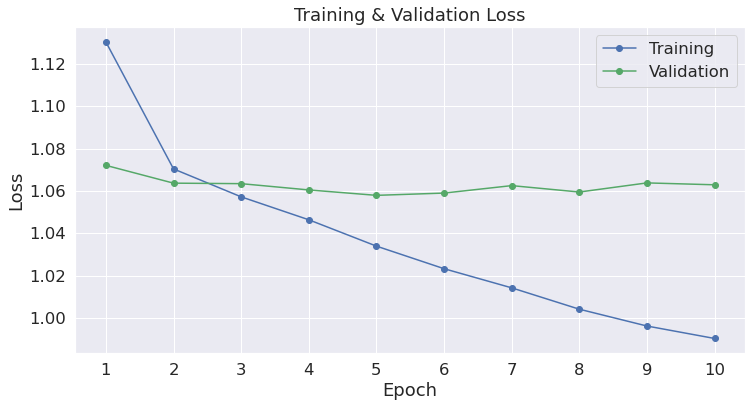

In [49]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([x+1 for x in range(exec_params['epochs'])])

plt.show()

## Plot accuracy and perplexity

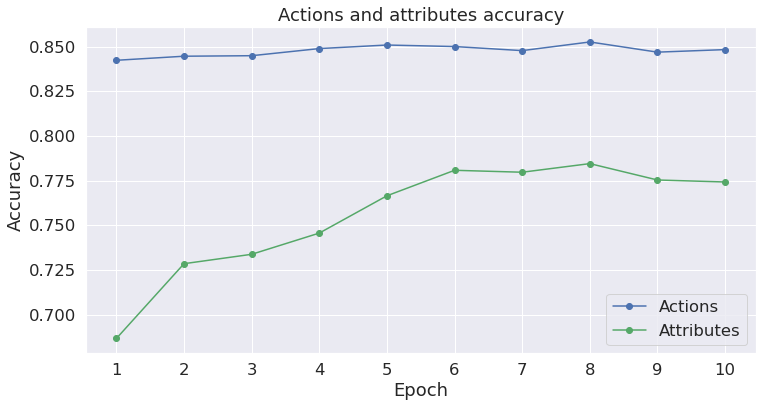

In [90]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

act_acc = [x['action_accuracy'] for x in df_stats.metrics]
att_acc = [x['attribute_accuracy'] for x in df_stats.metrics]
x_ticks = [x for x in range(len(act_acc))]

# Plot the learning curve.
plt.plot(act_acc, 'b-o', label="Actions")
plt.plot(att_acc, 'g-o', label="Attributes")

# Label the plot.
plt.title("Actions and attributes accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(ticks = x_ticks, labels = [str(x+1) for x in x_ticks])

plt.show()

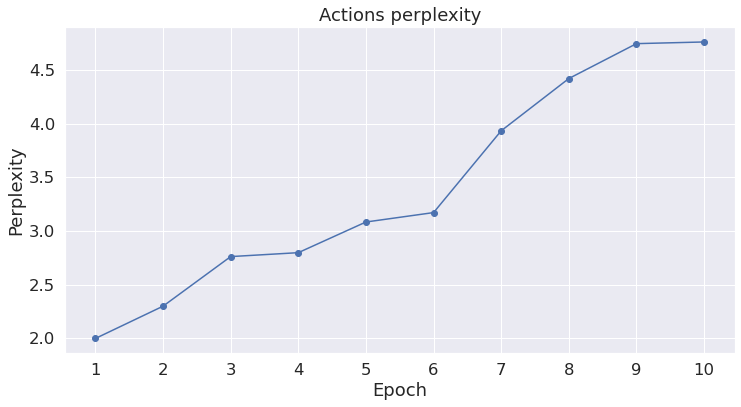

In [95]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

act_per = [x['action_perplexity'] for x in df_stats.metrics]
x_ticks = [x for x in range(len(act_acc))]

# Plot the learning curve.
plt.plot(act_per, 'b-o')

# Label the plot.
plt.title("Actions perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.xticks(ticks = x_ticks, labels = [str(x+1) for x in x_ticks])

plt.show()